In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

The HOSVD choose as orthonormal basis for $V_k$ the left singular vectors of $U_k$. That is, let the thin SVD of $U_k$ be 
$$
U_k=U_k\Sigma_kQ^T_k
$$
Where $U_k$ is the mode-k flattening
$$
U_k\in W_K\otimes\left(W_1\otimes\cdots\otimes W_{k-1}\otimes W_{k+1}\otimes\cdots\otimes W_d\right)^*
$$
thus it is a matrix of shape $I_k\times\left(\prod_{j\ne k}I_j\right)$. Moreover let $r_k=rank(U_k)$ then the multilinear rank of $U$ is given by
$$
mlrank(U)=(r_1,\cdots, r_d)
$$


In [2]:
def unfolding(n,A):
    shape = A.shape
    size = np.prod(shape)
    lsize = size // shape[n]
    sizelist = list(range(len(shape)))
    sizelist[n] = 0
    sizelist[0] = n
    return A.permute(sizelist).reshape(shape[n],lsize)

def modalsvd(n,A):
    nA = unfolding(n,A)
    return torch.svd(nA)

def hosvd(A):
    Ulist = []
    S = A
    for i,ni in enumerate(A.shape):
        u,_,_ = modalsvd(i,A)
        Ulist.append(u)
        S = torch.tensordot(S,u.t(),dims=([0],[0]))

    return S,Ulist

In [3]:
X = torch.rand(2,3,3)
G, U = hosvd(X)
print(X)
print(G)
print(U)

tensor([[[0.5524, 0.4880, 0.6938],
         [0.1407, 0.2116, 0.3629],
         [0.2288, 0.8487, 0.7884]],

        [[0.0994, 0.5730, 0.4054],
         [0.6595, 0.9953, 0.7143],
         [0.0448, 0.9962, 0.3510]]])
tensor([[[-0.2159,  0.3830, -0.2256],
         [ 0.6939,  0.1969,  0.2201],
         [-0.3184,  0.0259,  0.0106]],

        [[ 2.1875, -0.1919,  0.0268],
         [-0.3326, -0.0166, -0.0681],
         [ 0.4124,  0.3841,  0.0271]]])
[tensor([[ 0.6327, -0.7744],
        [ 0.7744,  0.6327]]), tensor([[-0.5022, -0.3342, -0.7975],
        [-0.5627,  0.8266,  0.0079],
        [-0.6566, -0.4528,  0.6032]]), tensor([[-0.3262, -0.7032, -0.6317],
        [-0.7451,  0.6025, -0.2859],
        [-0.5817, -0.3775,  0.7206]])]


In [7]:
U[1]@U[1].T

tensor([[ 1.0000e+00, -6.7756e-08,  1.5319e-07],
        [-6.7756e-08,  1.0000e+00, -4.6487e-08],
        [ 1.5319e-07, -4.6487e-08,  1.0000e+00]])

# SVD
In order to do the outer product it is possible to use the function `outer`  already implemented in the `numpy`  package 

In [2]:
vmin = 0
vmax = 1
image_bias = 1 # sometimes 1
def plot_svd(A, n_images = 5):
    n = min(len(A), n_images)
    imshow(image_bias-A, cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()
    U, S, V = svd(A)

    imgs = []
    for i in range(n):
        imgs.append(S[i]*np.outer(U[:,i],V[i]))

    combined_imgs = []
    for i in range(n):
        img = sum(imgs[:i+1])
        combined_imgs.append(img)
        
    fig, axes = plt.subplots(figsize = (n*n,n), nrows = 1, ncols = n, sharex=True, sharey=True)
    for num, ax in zip(range(n), axes):
        ax.imshow(image_bias-imgs[num], cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title(np.round(S[num],2), fontsize=80)
    plt.show()
    
    fig, axes = plt.subplots(figsize = (n*n,n), nrows = 1, ncols = n, sharex=True, sharey=True)
    for num, ax in zip(range(n), axes):
        ax.imshow(image_bias-combined_imgs[num], cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()

    return U,S,V

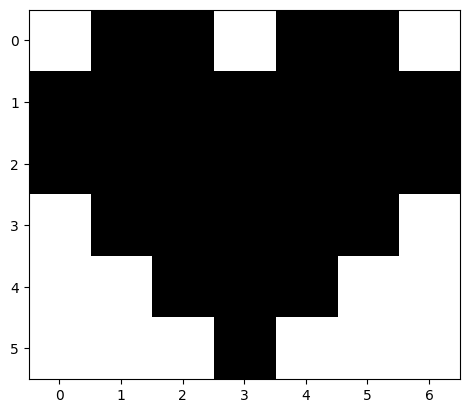

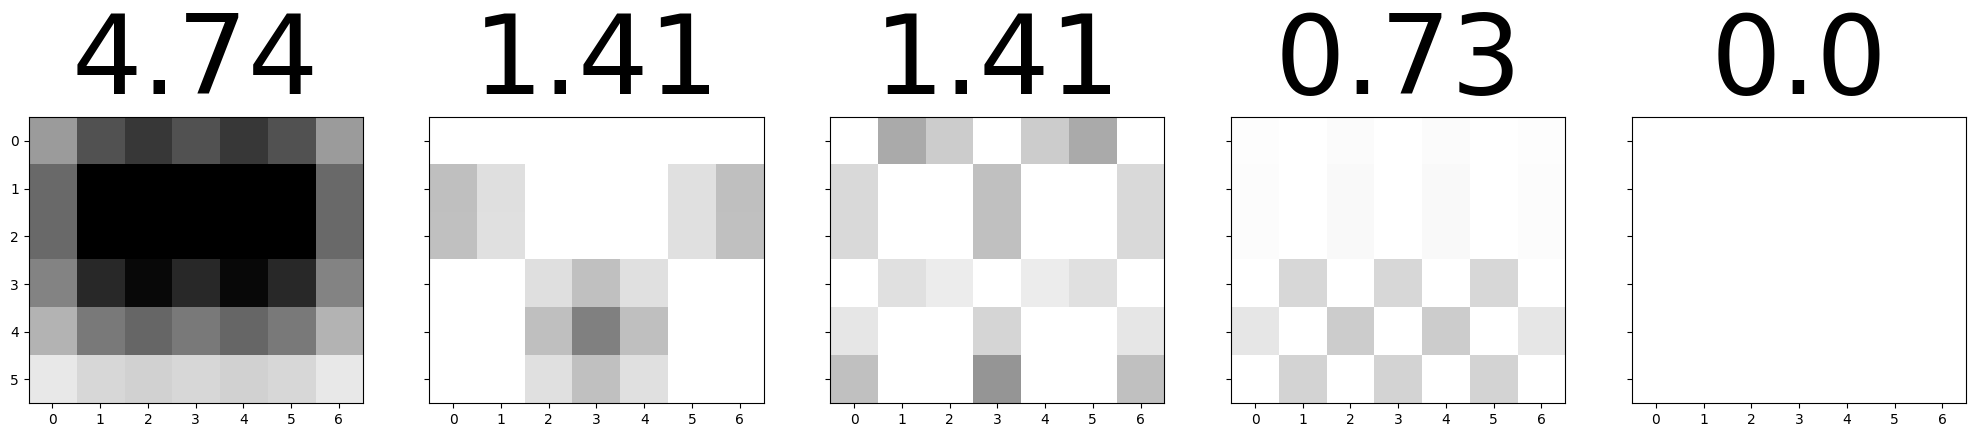

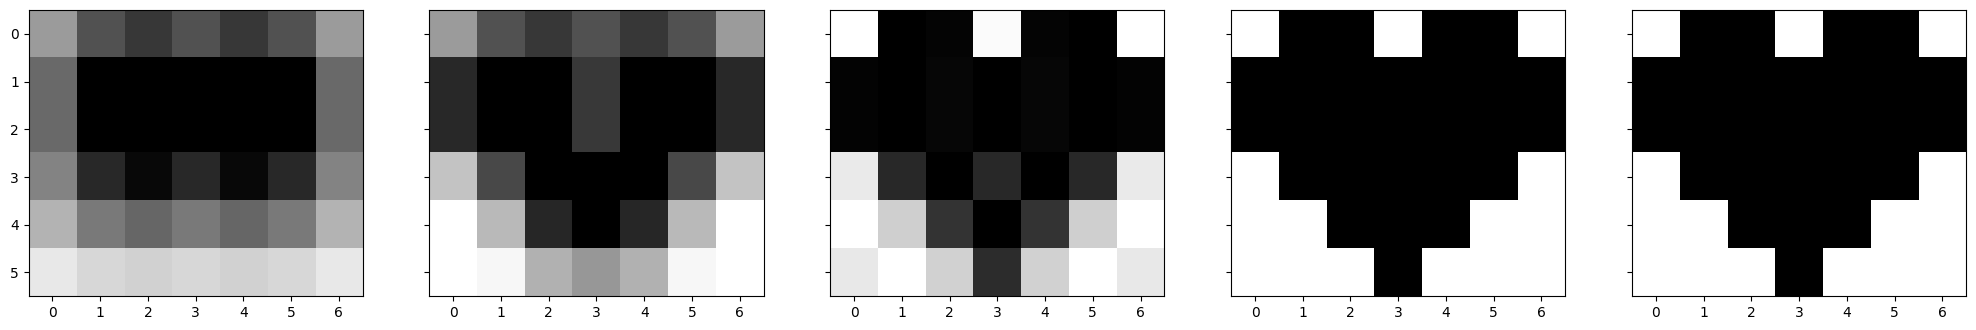

In [3]:
D = np.array([[0,1,1,0,1,1,0],
              [1,1,1,1,1,1,1],
              [1,1,1,1,1,1,1],
              [0,1,1,1,1,1,0],
              [0,0,1,1,1,0,0],
              [0,0,0,1,0,0,0],
             ])
U,S,V = plot_svd(D, n_images= 5)

In [4]:
# Define the transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define the data loaders
batch_size = 512

torch.Size([1, 28, 28])
the compression is at 0.3635204081632653


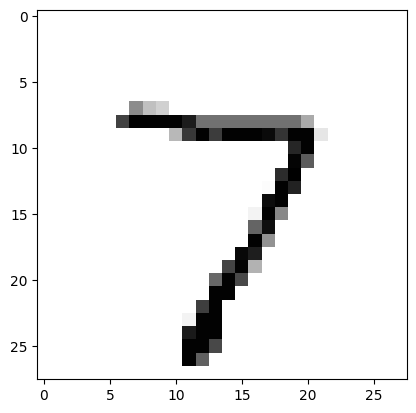

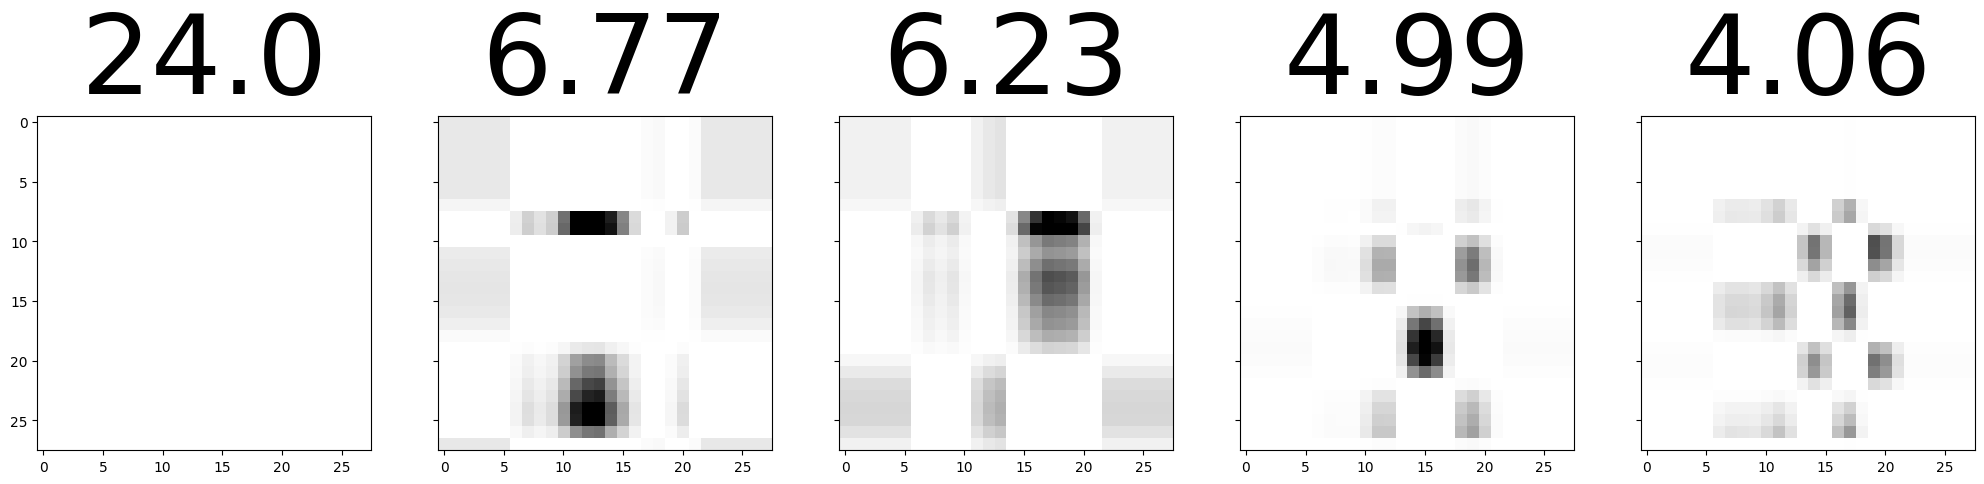

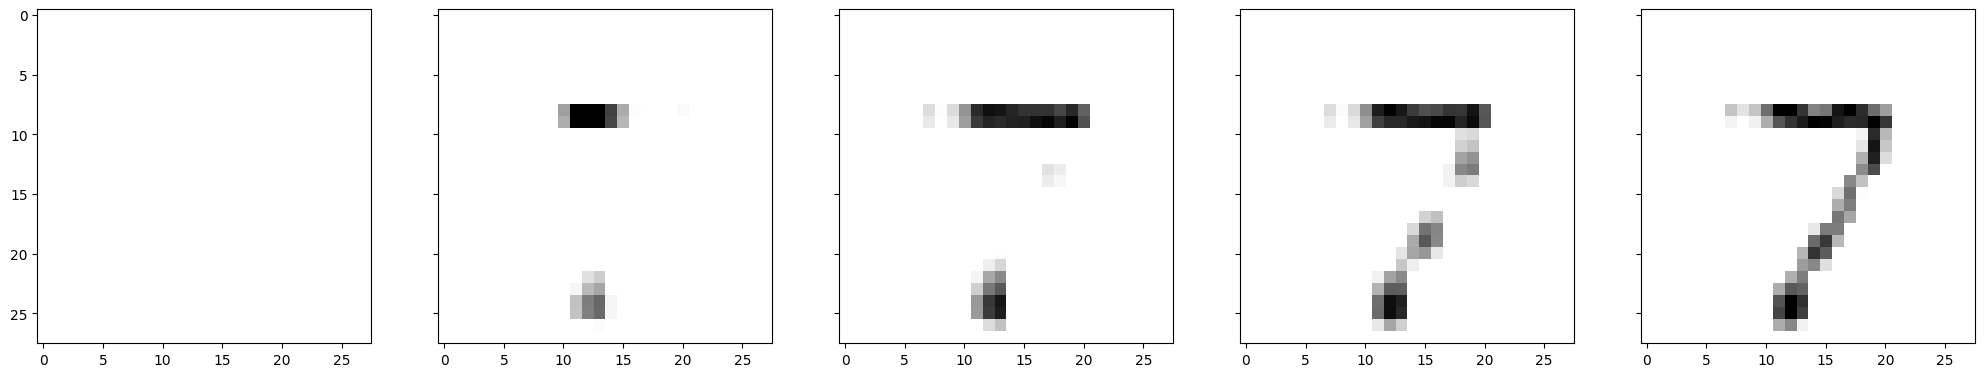

In [5]:
image, label = next(iter(test_dataset))
print(image.shape)
n_images=5
print(f"the compression is at {n_images*(28*2+1)/28**2}")
U,S,V = plot_svd(image.numpy().squeeze(), n_images=n_images)

In [6]:
batch, label = next(iter(train_dataset))
batch.shape

torch.Size([1, 28, 28])

# Model 

In [7]:
class classifier(nn.Module):
    def __init__(self, n_images:int, n_classes):
        super(classifier, self).__init__()
        self.n_images = n_images
        in_features = (2*28+1)*n_images
        self.classifier = nn.Sequential(nn.Linear(in_features = in_features, out_features = 256), 
                                        nn.ReLU(True), 
                                        nn.BatchNorm1d(256),
                                        nn.Linear(256, 128),
                                        nn.ReLU(True), 
                                        nn.Linear(128, n_classes), 
                                        nn.Softmax(-1))
    def forward(self, x):
        x = self.classifier(x)
        return x

# Optimization

In [8]:
def training(model, 
             train_loader, 
             val_loader, 
             num_epochs, 
             criterion, 
             optimizer):
    loss_train = []
    loss_val = []
    accuracy_train = []
    accuracy_val = []
                 
    be = np.inf
    bm = model
    model.train()
    loss_train = []
    
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        val_accuracy = 0.0
        for batch, label in train_loader:
            # Forward pass
            outputs = model(batch.to(device))
            loss = criterion(outputs, label.to(device))
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # storing the accuracy and loss
            _, val_predicted = torch.max(outputs, 1)
            val_accuracy += (val_predicted == label.to(device)).sum().item() 
            running_loss += loss.item()
            
        accuracy_train.append(val_accuracy/len(train_loader.dataset))
        loss_train.append(running_loss)

        # Testing the autoencoder
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            running_loss = 0.0
            val_accuracy = 0.0
            for batch, label in val_loader:
                # Forward pass
                outputs = model(batch.to(device))
                loss = criterion(outputs, label.to(device))
                
                # storing the accuracy and loss
                _, val_predicted = torch.max(outputs, 1)
                val_accuracy += (val_predicted == label.to(device)).sum().item() 
                running_loss += loss.item()
                
            accuracy_val.append(val_accuracy/len(val_loader.dataset))
            loss_val.append(running_loss)
        
        if loss_val[-1]<be:
            be = loss_val[-1]
            bm = model
            
    return bm, loss_train, loss_val, accuracy_train, accuracy_val


# Compression

An image is a 3D tensor characterized by $C\times H\times W$ (Channels, Hight and Width) so the number of elements that are presented in the tensor will be $CHW$. The idea is to find the maximum number of 1D vectors that approximate the image but still have a less number of elements.

Below you can see how the compression obtained through SVD varies. The upper limit indicates the point beyond which the number of elements given by the 1D tensor are greater than the elements in the input itself.

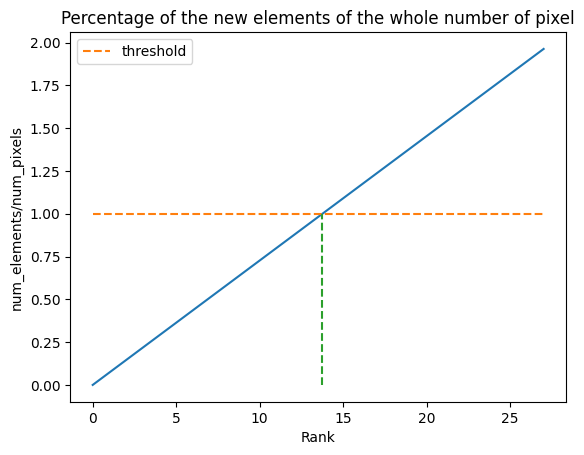

In [9]:
n_images_list = range(28)
compression = [(2*28+1)*x/28**2 for x in n_images_list]
plt.plot(n_images_list, compression)
plt.xlabel("Rank")
plt.ylabel("num_elements/num_pixels")
plt.plot(n_images_list, [1]*len(n_images_list), linestyle='dashed', label = "threshold")
plt.plot([28**2/(2*28+1)]*10, np.linspace(0,1,10), linestyle = 'dashed')
plt.legend()
plt.title("Percentage of the new elements of the whole number of pixel")
plt.show()

# Estimates

In [10]:
d = {}
emb = {}
frobenius = {}
for i in range(10):
    _, S, _ = torch.svd(train_dataset.data[train_dataset.targets==i].float())
    emb[i] = S[:,:3].numpy()
    d[i] = S.mean(0)
    frobenius[i] = torch.mean(torch.norm(train_dataset.data[train_dataset.targets==i].float(), dim=(1, 2), p=2)).item()

df=pd.DataFrame()
for i in range(10):
    tmp = pd.DataFrame(emb[i])
    tmp['digit']= [i]*len(tmp)
    df = pd.concat((df,tmp))

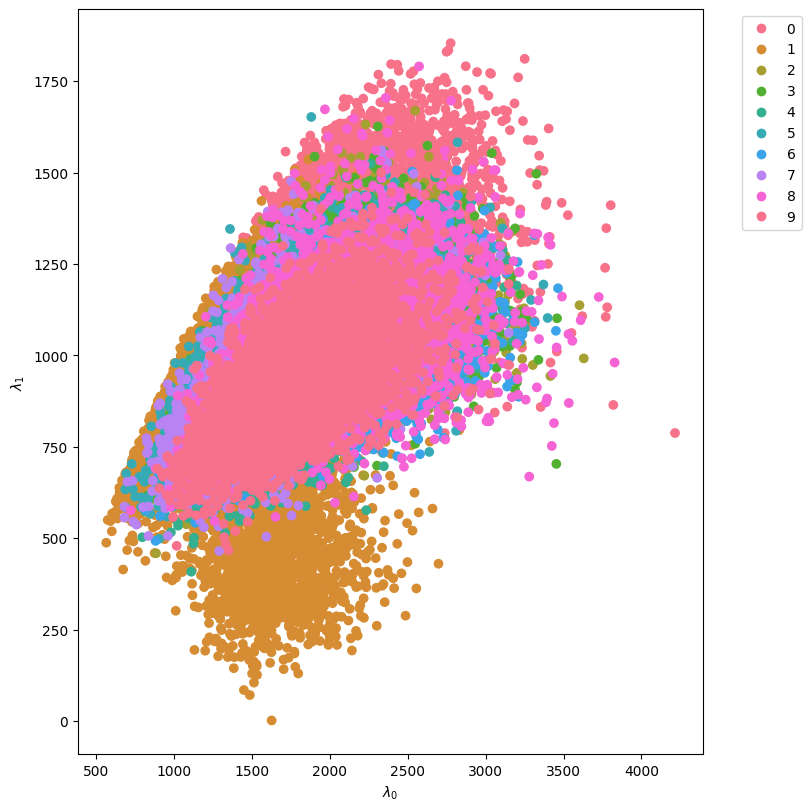

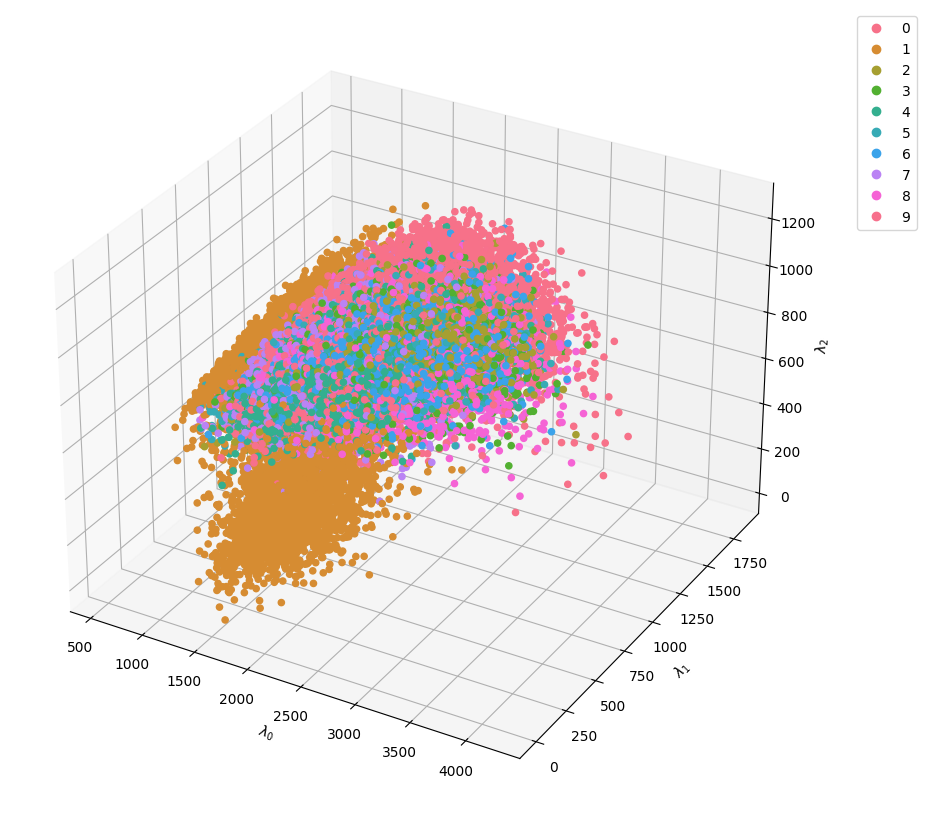

In [11]:
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

fig, ax = plt.subplots(figsize = (8, 8),
                       constrained_layout=True)
sc = plt.scatter(df[0],
                 df[1],
                 c=list(df.digit.values), 
                 marker = 'o', 
                 cmap = cmap, 
                 alpha = 1)
ax.set_xlabel('$\lambda_1$')
ax.set_ylabel('$\lambda_2$')
lgd = ax.legend(*sc.legend_elements(), 
           bbox_to_anchor=(1.05, 1), 
           loc=2
      )


fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
sc = ax.scatter(df[0].values,
           df[1].values,
           df[2].values, 
           c = list(df.digit.values), 
           marker = 'o', 
           cmap = cmap, 
           alpha = 1)
ax.set_xlabel('$\lambda_1$')
ax.set_ylabel('$\lambda_2$')
ax.set_zlabel('$\lambda_3$')
lgd = ax.legend(*sc.legend_elements(), 
           bbox_to_anchor=(1.05, 1), 
           loc=2
      )

In [12]:
error = {}
for i in range(10):
    n_im_err = []
    for n_images in n_images_list:
        err = torch.norm(d[i][n_images:], 2)
        n_im_err.append(err.item())
    error[i] = n_im_err  

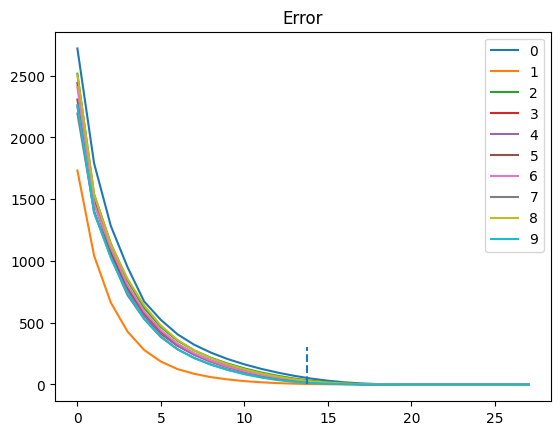

In [13]:
for i in range(10):
    plt.plot(error[i], label = f"{i}")
    
plt.plot([28**2/(2*28+1)]*1000, np.linspace(0,300,1000), linestyle = 'dashed')
plt.title("Error")
plt.legend()
plt.show()

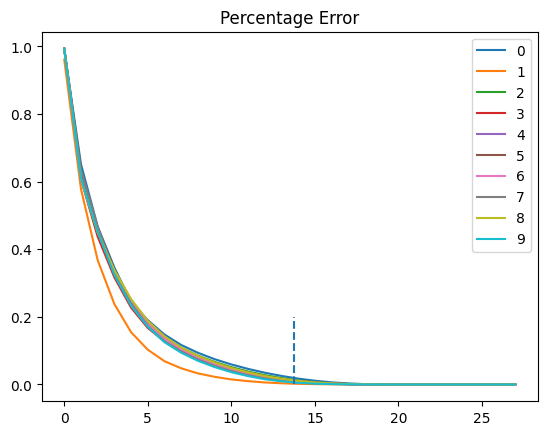

In [14]:
for i in range(10):
    plt.plot([x/frobenius[i] for x in error[i]], label = f"{i}")
plt.plot([28**2/(2*28+1)]*10, np.linspace(0,0.2,10), linestyle = 'dashed')
plt.title("Percentage Error")
plt.legend()
plt.show()

In [15]:
class my_dataset(Dataset):
    def __init__(self, 
                 images, 
                 labels,
                 n_tensor:int):
        V, S, D = torch.svd(images)
        V = torch.transpose(V[:,:,:n_tensor], -2,-1).flatten(-2)
        D = torch.transpose(D[:,:,:n_tensor], -2,-1).flatten(-2)
        S = S[:,:n_tensor]
        self.x = torch.cat((V, D, S),-1) 
        self.y = labels
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

100%|█████████████████████████████████████████| 150/150 [03:40<00:00,  1.47s/it]


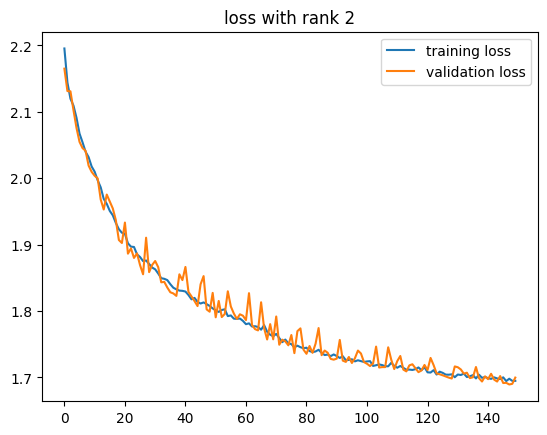

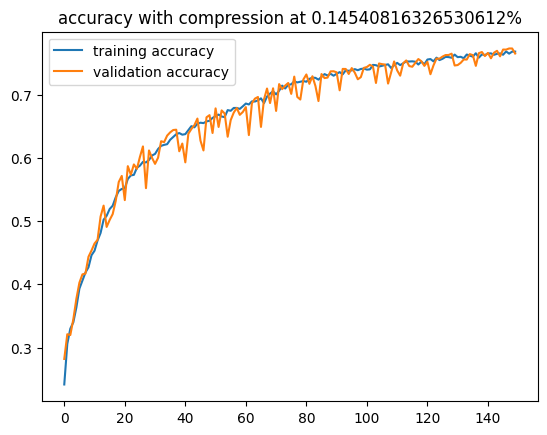

100%|█████████████████████████████████████████| 150/150 [03:23<00:00,  1.36s/it]


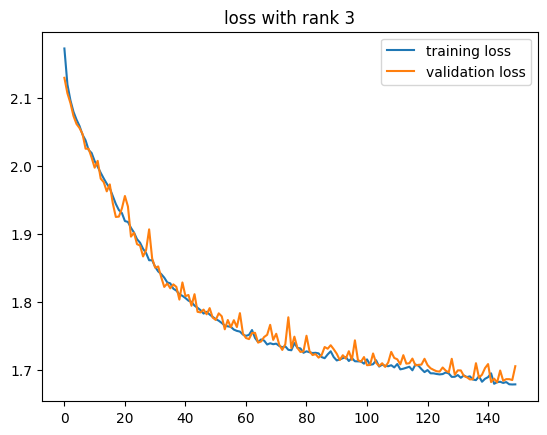

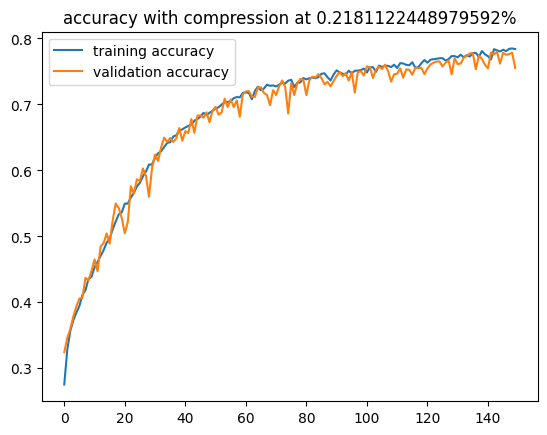

100%|█████████████████████████████████████████| 150/150 [02:39<00:00,  1.06s/it]


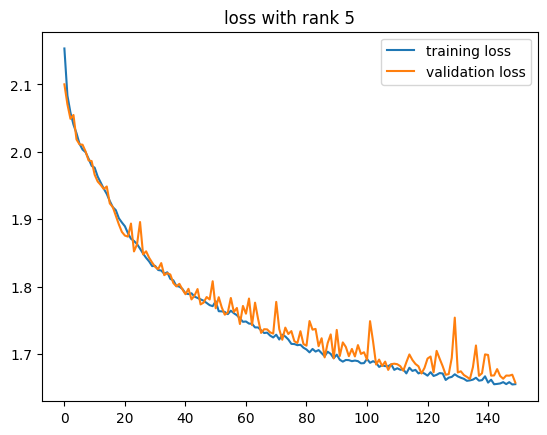

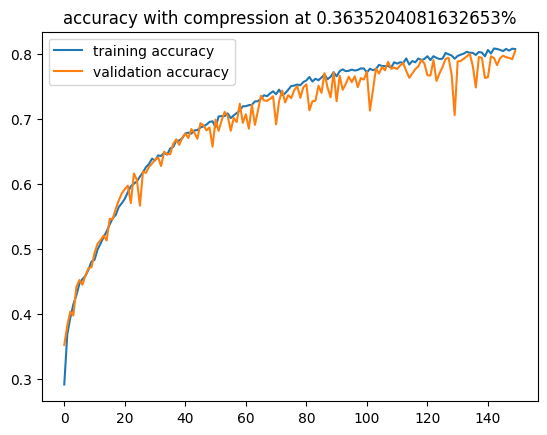

100%|█████████████████████████████████████████| 150/150 [02:49<00:00,  1.13s/it]


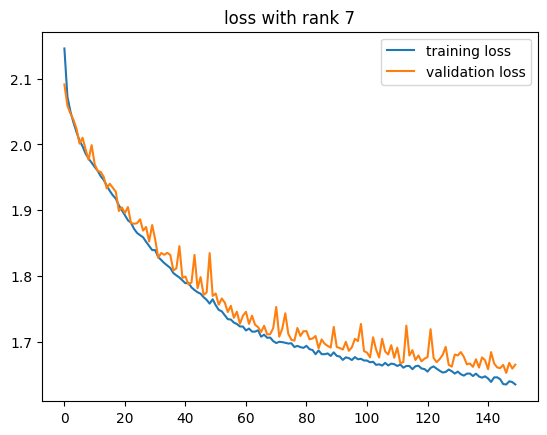

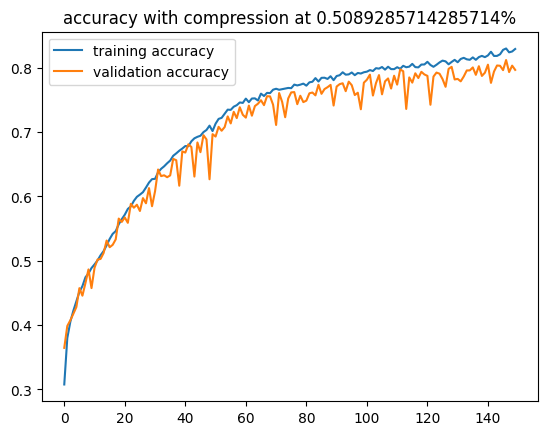

100%|█████████████████████████████████████████| 150/150 [03:12<00:00,  1.28s/it]


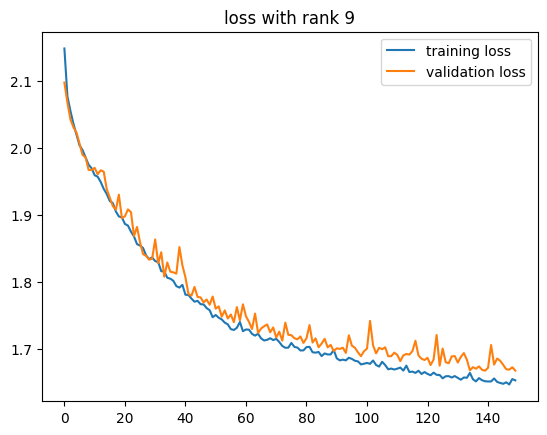

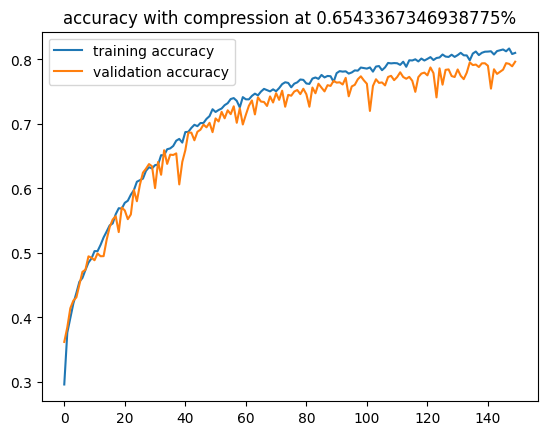

100%|█████████████████████████████████████████| 150/150 [03:17<00:00,  1.31s/it]


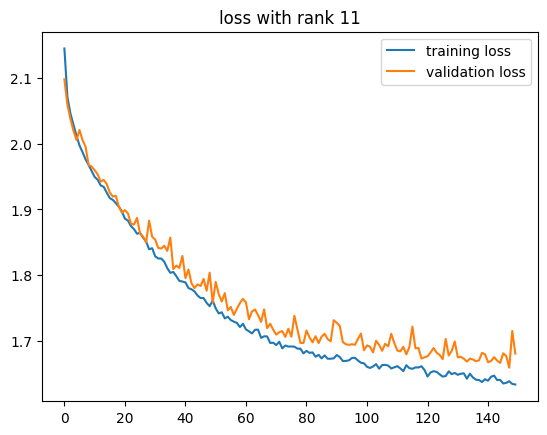

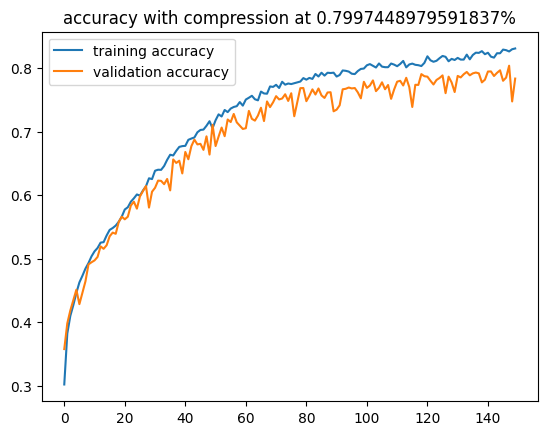

100%|█████████████████████████████████████████| 150/150 [03:31<00:00,  1.41s/it]


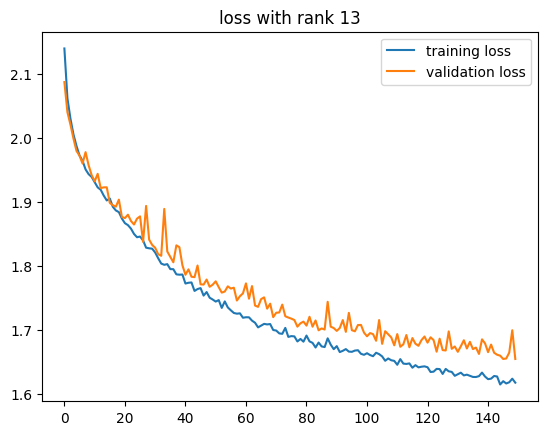

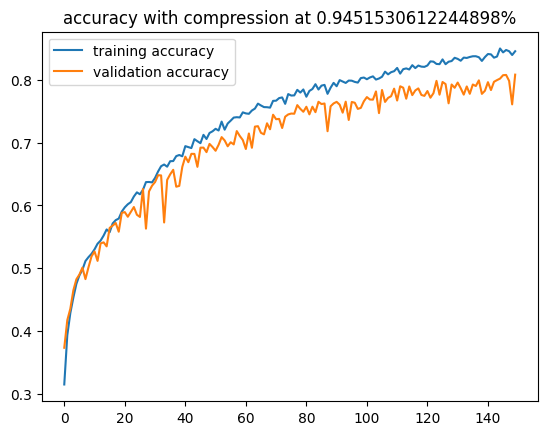

In [15]:
# Step 4: Define Loss Function and Optimizer
device = torch.device("cuda")
top_accuracy_train = {}
top_accuracy_val = {}
for n_images in [2, 3, 5, 7, 9, 11, 13]:
    model = classifier(n_images = n_images, 
                       n_classes = 10).to(device)
    
    criterion = nn.CrossEntropyLoss()  # Assuming a classification problem
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    
    tmp_train = my_dataset(images = train_dataset.data.float(), 
                           labels = train_dataset.targets, 
                           n_tensor = n_images)
    tmp_train = DataLoader(tmp_train, batch_size=batch_size, shuffle = True)

    tmp_val = my_dataset(images = test_dataset.data.float(), 
                           labels = test_dataset.targets, 
                           n_tensor = n_images)
    tmp_val = DataLoader(tmp_val, batch_size = batch_size, shuffle = True)
    
    model, loss_train, loss_val, accuracy_train, accuracy_val = training(model, 
                                                                         train_loader = tmp_train, 
                                                                         val_loader = tmp_val, 
                                                                         num_epochs = 150, 
                                                                         criterion = criterion, 
                                                                         optimizer = optimizer)
    torch.save(model.state_dict(), f"/home/andrea/Scrivania/Università/td/models/model{n_images}.pt")
    plt.plot(np.array(loss_train)/len(tmp_train), label = 'training loss')
    plt.plot(np.array(loss_val)/len(tmp_val), label = 'validation loss')
    plt.title(f'loss with rank {n_images}')
    plt.legend()
    plt.savefig(f"/home/andrea/Scrivania/Università/td/images/loss_{n_images}.png")
    plt.show()

    
    plt.plot(accuracy_train, label = 'training accuracy')
    plt.plot(accuracy_val, label = 'validation accuracy')
    plt.title(f'accuracy with compression at {(2*28+1)*model.n_images/28**2}%')
    plt.legend()
    plt.savefig(f"/home/andrea/Scrivania/Università/td/images/accuracy_{n_images}.png")
    plt.show()

    top_accuracy_train[n_images] = max(accuracy_train)
    top_accuracy_val[n_images] = max(accuracy_val)
    
top_accuracy_train = pd.DataFrame(top_accuracy_train.items())
top_accuracy_val = pd.DataFrame(top_accuracy_val.items())
top_accuracy_train.columns = ['n_image', 'train']
top_accuracy_val.columns = ['n_image', 'val']
df = pd.merge(top_accuracy_train,top_accuracy_val, on='n_image')
df.to_csv(f"/home/andrea/Scrivania/Università/td/performance.csv")

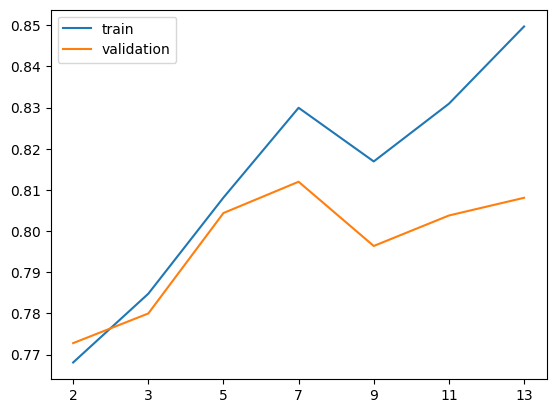

In [16]:
fig, ax = plt.subplots()
ax.plot(df.train, label = 'train')
ax.plot(df.val, label = 'validation')
ax.set_xticks(range(len(df)))
ax.set_xticklabels(df.n_image)
ax.legend()
plt.show()